# Reviving, reproducing and revisiting Axelrod's second tournament

In [1]:
import pathlib
import re

import axelrod as axl
import axelrod_fortran as axlf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

assert axl.__version__ == '4.2.0', axl.__version__
assert axlf.__version__ == '0.4.4', axlf.__version__
assert matplotlib.__version__ == '2.2.2', matplotlib.__version__ 
assert np.__version__ == '1.14.3', np.__version__
assert pd.__version__ == '0.23.0', pd.__version__
assert sklearn.__version__ == '0.19.0', sklearn.__version__

%matplotlib inline

# Building the appendices

In [2]:
with open("../assets/list_of_original_tournament_players.tex", "w") as f:
    for name in axlf.second_tournament_strategies:
        dictionary = axlf.characteristics[name]
        f.write("\item {name} - Original rank: {original_rank}. Authored by {author}\n".format(name=name, 
                                                             author=dictionary["author"],
                                                             original_rank=dictionary["original_rank"]))

## Reproducing the original tournament

In [3]:
def get_turns(filename):
    """
    Read the number of turns if included in the file name
    """
    match = re.search("[0-9]+(?=(_turns))", str(filename))
    return int(match.group(0))

def get_repetitions(filename):
    """
    Read the number of repetitions if included in the file name
    """
    match = re.search("[0-9]+(?=(_repetitions))", str(filename))
    return int(match.group(0))

def read_tournament_repetitions(files, player_names=None):
    """
    Read the scores from a collection of gz files 
    representing repetitions of tournaments.
    """
    number_of_opponents = len(player_names) - 1
    dfs = []
    for gz_path in files:
        dfs.append(pd.read_csv(str(gz_path), header=None).iloc[:,0:number_of_opponents + 1])
        
        turns = get_turns(gz_path)
        
        dfs[-1] /= turns * (number_of_opponents)  # Scale all metrics
        dfs[-1].columns = player_names
        
    df = pd.concat(dfs, ignore_index=True)
    return df

In [4]:
original_tournament_data_path = pathlib.Path("./data/original_tournament/")
original_tournament_scores = read_tournament_repetitions(
                                   files=original_tournament_data_path.glob("*scores.gz"), 
                                   player_names=axlf.second_tournament_strategies)

In [5]:
original_tournament_scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,k84r,k85r,k86r,k87r,k88r,k89r,k90r,k91r,k92r,krandomc
0,2.746175,2.823304,2.043424,2.545699,2.870761,1.461538,2.696754,2.701096,2.745037,2.703474,...,2.860215,2.677523,2.711332,2.676489,2.738007,2.226840,2.742039,2.668631,2.911807,1.686001
1,2.741832,2.886787,2.031224,2.569065,2.874586,1.483664,2.694065,2.687655,2.759822,2.680624,...,2.869520,2.667390,2.717432,2.706782,2.785877,2.211022,2.725496,2.753309,2.915219,1.632134
2,2.731079,2.851944,2.058623,2.558726,2.849979,1.497932,2.685587,2.690343,2.710608,2.651468,...,2.862490,2.674628,2.720740,2.703991,2.776365,2.189309,2.727254,2.700993,2.927523,1.645988
3,2.754032,2.817204,2.014992,2.546112,2.864041,1.476737,2.682899,2.697994,2.741729,2.699442,...,2.863627,2.705645,2.714640,2.698821,2.793838,2.215261,2.737490,2.702957,2.924421,1.605149
4,2.740695,2.838296,2.057072,2.553763,2.851944,1.495451,2.656534,2.686931,2.747519,2.739247,...,2.864557,2.685897,2.715778,2.687552,2.753929,2.194686,2.739661,2.746071,2.927316,1.687862


In [6]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    
    df["Author"] = [axlf.characteristics[name]["author"] for name in df.index]
    df["Original rank"] = [axlf.characteristics[name]["original_rank"] for name in df.index]

    return df

original_score_summary = summarise_scores(original_tournament_scores)

original_score_summary.head()

,mean,std,min,5%,25%,50%,75%,95%,max,Author,Original rank
k92r,2.921853,0.008376,2.879346,2.909300,2.915259,2.921940,2.928246,2.934698,2.939673,Anatol Rapoport,1
k42r,2.911924,0.011431,2.869344,2.893093,2.904326,2.912634,2.920635,2.928152,2.940511,Otto Borufsen,3
k75r,2.880968,0.024212,2.772623,2.835829,2.866419,2.884025,2.898361,2.915515,2.948302,Paul D Harrington,8
k49r,2.873871,0.014202,2.794721,2.847670,2.865627,2.875576,2.883892,2.893801,2.912442,Rob Cave,4
k60r,2.869107,0.029845,2.758431,2.819124,2.848532,2.869210,2.894009,2.912186,2.943164,Jim Graaskamp and Ken Katzen,6


In [7]:
def violon_plot(scores, summary, filename):
    number_of_players = len(scores.columns)
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / (1.5 * 1.414)
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 
    
    summary.sort_values("Original rank", inplace=True)

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xlabel("Strategy file name, ordered by original rank", fontsize=20)
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    
    
    fig.tight_layout()
    fig.savefig(filename, transparent=True);

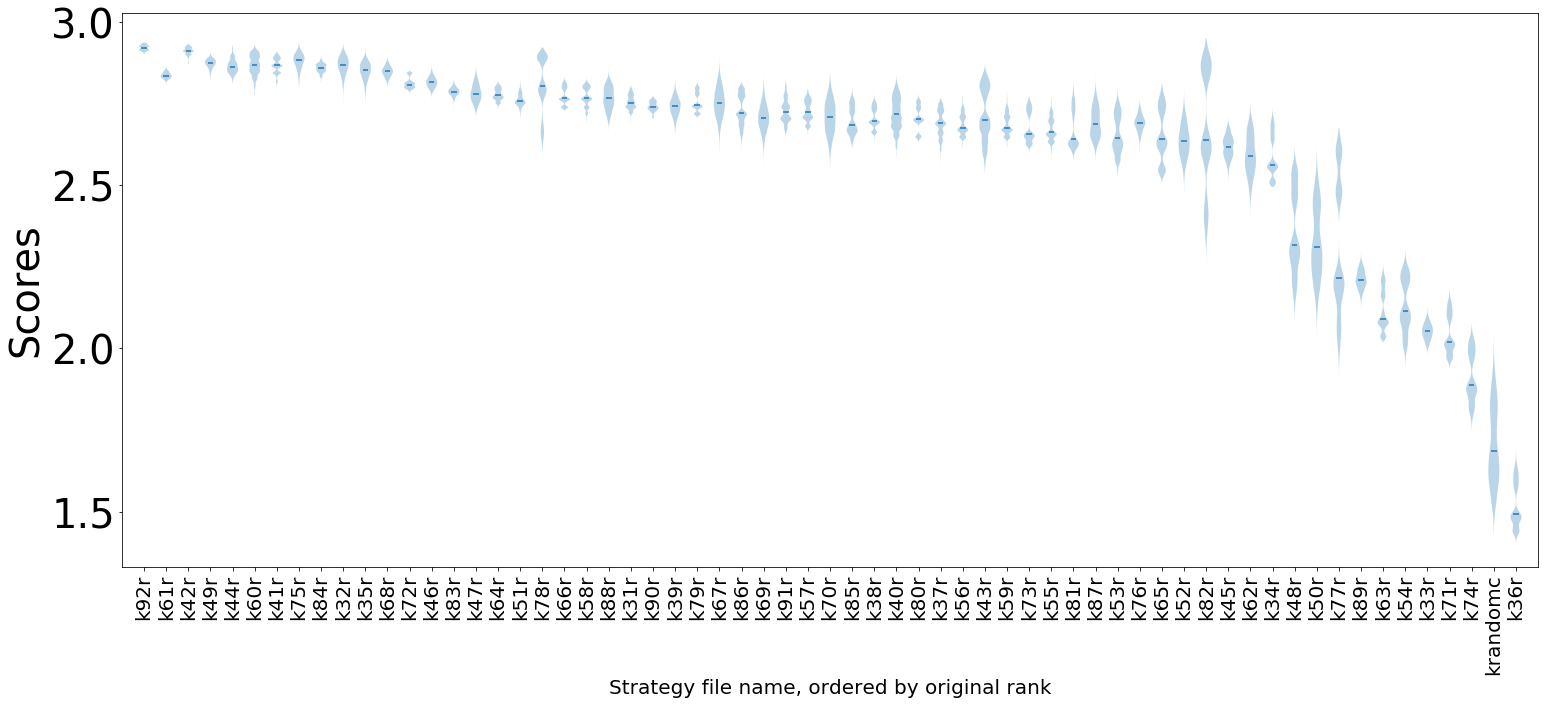

In [8]:
violon_plot(original_tournament_scores, original_score_summary, "../assets/original_scores_boxplots.pdf")
plt.ylabel("Scores", fontsize=40);

Let us consider the ranks over all repetitions of the tournaments (we have a lot of tournaments).

In [9]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    
    df["Author"] = [axlf.characteristics[name]["author"] for name in df.index]
    df["Original rank"] = [axlf.characteristics[name]["original_rank"] for name in df.index]
    
    return df

original_rank_summary = summarise_ranks(original_tournament_scores)

original_rank_summary.head(15)

,mean,std,min,5%,25%,50%,75%,95%,max,Author,Original rank
k92r,1.48426,0.745026,1,1.0,1.0,1.0,2.0,3.0,9,Anatol Rapoport,1
k42r,1.85296,0.743681,1,1.0,1.0,2.0,2.0,3.0,8,Otto Borufsen,3
k75r,5.38002,2.725599,1,2.0,3.0,5.0,7.0,11.0,17,Paul D Harrington,8
k49r,6.39186,2.458288,1,3.0,4.0,6.0,8.0,11.0,16,Rob Cave,4
k60r,6.93462,3.258441,1,3.0,4.0,6.0,9.0,13.0,18,Jim Graaskamp and Ken Katzen,6
k41r,7.33200,2.460930,2,4.0,6.0,7.0,9.0,12.0,16,Herb Weiner,7
k32r,7.35394,3.388014,1,3.0,4.0,7.0,10.0,13.0,26,Charles Kluepfel,10
k44r,7.84164,3.834020,1,3.0,4.0,8.0,11.0,14.0,19,William Adams,5
k84r,8.52962,2.206764,2,5.0,7.0,9.0,10.0,12.0,17,T Nicolaus Tideman and Paula Chieruzz,9
k35r,9.64100,3.309392,1,4.0,7.0,10.0,12.0,15.0,28,Abraham Getzler,11


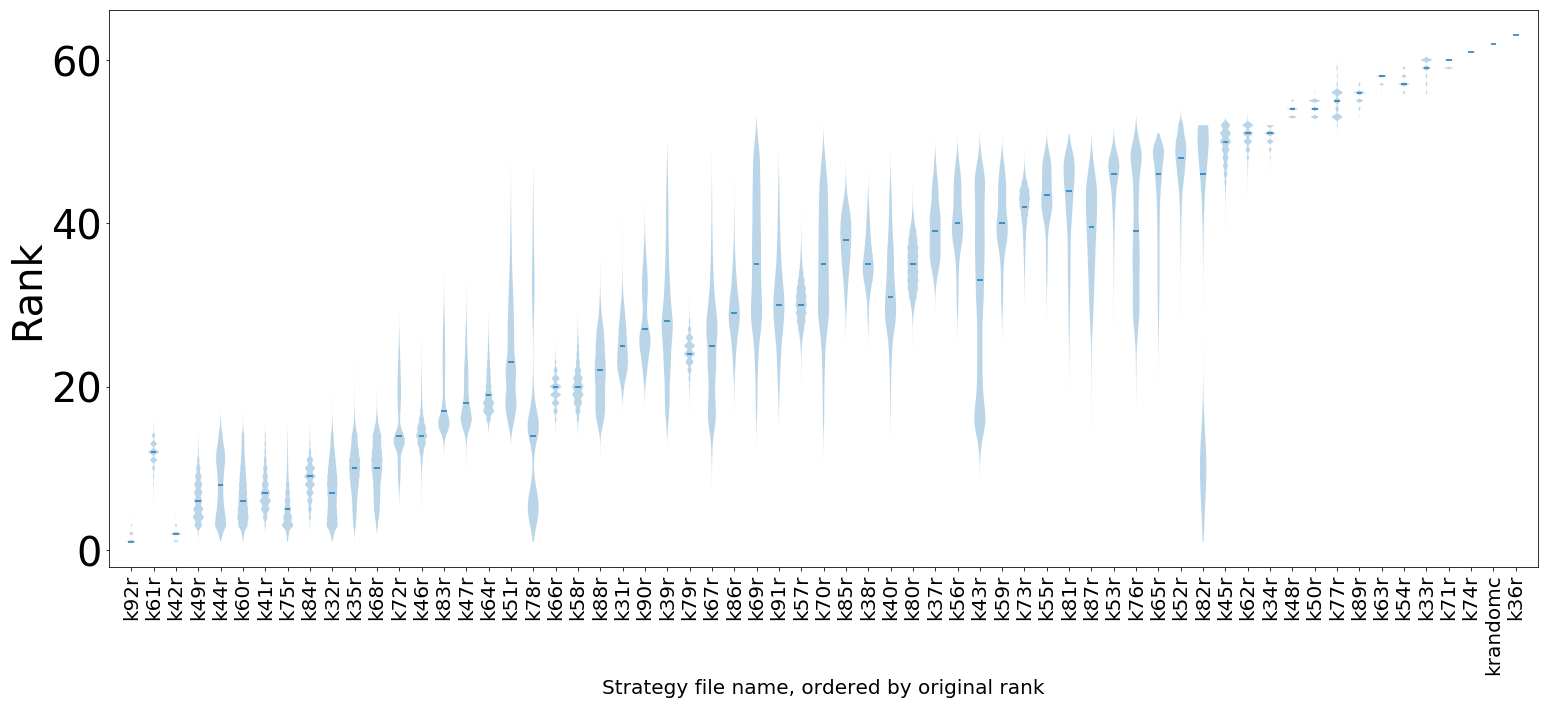

In [10]:
violon_plot(original_tournament_scores.rank(axis=1, ascending=False), 
            original_rank_summary, "../assets/original_ranks_boxplots.pdf")
plt.ylabel("Rank", fontsize=40);

Our scores (calculated above) ignore self interactions. Our payoffs do not:

In [11]:
def read_payoff_matrix(files, number_of_fortran_strategies=None):
    arrays = []
    turns = []
    repetitions = 0
    for gz_path in files:
        repetitions += get_repetitions(gz_path)
        arrays.append(np.array(pd.read_csv(str(gz_path), header=None)))  # Read through pd to deal with float conversion
        turns.append(get_turns(str(gz_path)))
    matrix = sum(array * turn for turn, array in zip(turns, arrays)) / sum(turns)
    
    if number_of_fortran_strategies is None:
        number_of_fortran_strategies = len(axlf.second_tournament_strategies)

    assert matrix.shape[0] >= number_of_fortran_strategies * 2
    
    payoff_matrix = matrix[:-(number_of_fortran_strategies),:-(number_of_fortran_strategies)]

    self_interactions_matrix = matrix[-number_of_fortran_strategies:,:number_of_fortran_strategies] 
    padded_self_interactions_matrix = np.zeros(payoff_matrix.shape)
    padded_self_interactions_matrix[:self_interactions_matrix.shape[0],:self_interactions_matrix.shape[1]] = self_interactions_matrix
    payoff_matrix = padded_self_interactions_matrix + payoff_matrix
    return payoff_matrix, repetitions

In [12]:
original_tournament_payoff_matrix, original_repetitions = read_payoff_matrix(original_tournament_data_path.glob("*payoff_matrix.gz"))

In [13]:
scores = pd.DataFrame(original_tournament_payoff_matrix, 
                      axlf.second_tournament_strategies, 
                      columns=axlf.second_tournament_strategies)

In [14]:
scores["Scores"] = np.mean(original_tournament_payoff_matrix, axis=1)
scores["Rank"] = scores["Scores"].rank(ascending=False).astype(int)
scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in scores.index]
scores["Author"] =  [axlf.characteristics[name]["author"] for name in scores.index]
scores.sort_values("Original Rank", inplace=True)

In [15]:
scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,k88r,k89r,k90r,k91r,k92r,krandomc,Scores,Rank,Original Rank,Author
k92r,3.0,3.0,2.900662,3.0,3.0,1.258956,3.0,3.0,2.993377,3.0,...,3.0,2.635762,3.0,3.0,3.0,2.245785,2.878481,1,1,Anatol Rapoport
k61r,3.0,3.0,2.854305,3.0,3.0,1.112752,3.0,3.0,2.993377,3.0,...,3.0,2.530076,3.0,3.0,3.0,1.879119,2.790874,12,2,Danny C Champion
k42r,3.0,3.0,2.137748,3.0,3.0,1.199543,3.0,3.0,2.993377,3.0,...,3.0,2.621192,3.0,3.0,3.0,2.798004,2.860686,2,3,Otto Borufsen
k49r,3.0,3.0,2.284076,3.0,3.0,1.284097,3.0,3.0,2.905704,3.0,...,3.0,2.370407,3.0,3.0,3.0,2.693891,2.826207,3,4,Rob Cave
k44r,3.0,3.0,2.361603,3.0,3.0,1.228131,3.0,3.0,2.794313,3.0,...,3.0,2.446248,3.0,3.0,3.0,2.202598,2.826062,4,5,William Adams


In [16]:
original_tournament_with_py_ch_data_path = pathlib.Path("./data/original_tournament_with_python_champion/")
original_tournament_with_py_ch_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_py_ch_data_path.glob("*payoff_matrix.gz"),
                                                                     number_of_fortran_strategies=62)

In [18]:
player_names = [name for name in axlf.second_tournament_strategies if name != "k61r"] + ["k61r"]
assert len(player_names), original_tournament_with_py_ch_payoff_matrix.shape == (63, (63, 63))

In [19]:
py_ch_scores = pd.DataFrame(original_tournament_with_py_ch_payoff_matrix, 
                        player_names, 
                        columns=player_names)
py_ch_scores["Scores"] = np.mean(original_tournament_with_py_ch_payoff_matrix, axis=1)
py_ch_scores["Rank"] = py_ch_scores["Scores"].rank(ascending=False).astype(int)
py_ch_scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in py_ch_scores.index]
py_ch_scores["Author"] =  [axlf.characteristics[name]["author"] for name in py_ch_scores.index]
py_ch_scores.sort_values("Original Rank", inplace=True)

Largest error in scores:

In [20]:
max(abs(py_ch_scores["Scores"] - scores["Scores"]))

0.001709676471683963

In [23]:
fortran_strategies = [s for s in axlf.second_tournament_strategies 
                      if axlf.characteristics[s]["axelrod-python_class"] is None]
assert len(fortran_strategies) == 39

In [24]:
fortran_strategies = [s for s in axlf.second_tournament_strategies 
                      if axlf.characteristics[s]["axelrod-python_class"] is None]
python_strategies = [s for s in axlf.second_tournament_strategies 
                     if axlf.characteristics[s]["axelrod-python_class"] is not None]

original_tournament_with_all_py_data_path = pathlib.Path("./data/original_tournament_with_python_implementations/")
original_tournament_with_all_py_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_all_py_data_path .glob("*payoff_matrix.gz"),
                                                                      number_of_fortran_strategies=len(fortran_strategies))

In [25]:
player_names = fortran_strategies + python_strategies
py_scores = pd.DataFrame(original_tournament_with_all_py_payoff_matrix, 
                         player_names, 
                         columns=player_names)
py_scores["Scores"] = np.mean(original_tournament_with_all_py_payoff_matrix, axis=1)
py_scores["Rank"] = py_scores["Scores"].rank(ascending=False).astype(int)
py_scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in py_scores.index]
py_scores["Author"] =  [axlf.characteristics[name]["author"] for name in py_scores.index]
py_scores.sort_values("Original Rank", inplace=True)

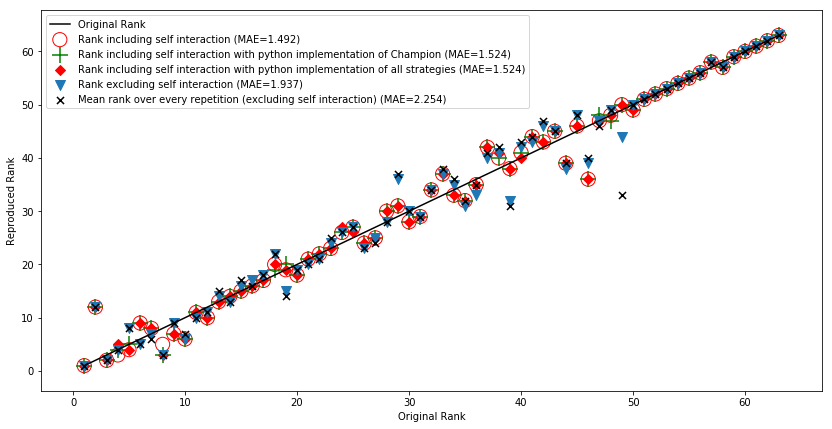

In [26]:
plt.subplots(1, figsize=(14, 7))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
self_interaction_py_ch_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                            py_ch_scores["Rank"])
self_interaction_py_all_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                              py_scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))
# TODO: Add more error calculations


plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], 
            label="Rank including self interaction (MAE={:.3f})".format(self_interaction_mean_abs_error),
            s=200,
            facecolors='none', edgecolors='r')
plt.scatter(py_scores["Original Rank"], py_ch_scores["Rank"], 
            label="Rank including self interaction with python implementation of Champion (MAE={:.3f})".format(self_interaction_py_ch_mean_abs_error),
            s=250,
            facecolors='g',
            marker="+")
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Rank including self interaction with python implementation of all strategies (MAE={:.3f})".format(self_interaction_py_all_mean_abs_error),
            s=50,
            facecolors='r',
            marker="D")
plt.scatter(scores["Original Rank"], 
            original_score_summary["mean"].rank(ascending=False), 
            label="Rank excluding self interaction (MAE={:.3f})".format(excl_self_interaction_mean_abs_error), 
            s=100,
            marker="v",)
plt.scatter(scores["Original Rank"], original_rank_summary["mean"].rank(ascending=True), 
            label="Mean rank over every repetition (excluding self interaction) (MAE={:.3f})".format(mean_rank_mean_abs_error),
            s=50,
            marker="x",
            color="black")
plt.xlabel("Original Rank")
plt.ylabel("Reproduced Rank")
plt.legend()
plt.savefig("../assets/original_tournament_rankings_all_approaches.pdf", transparent=True);

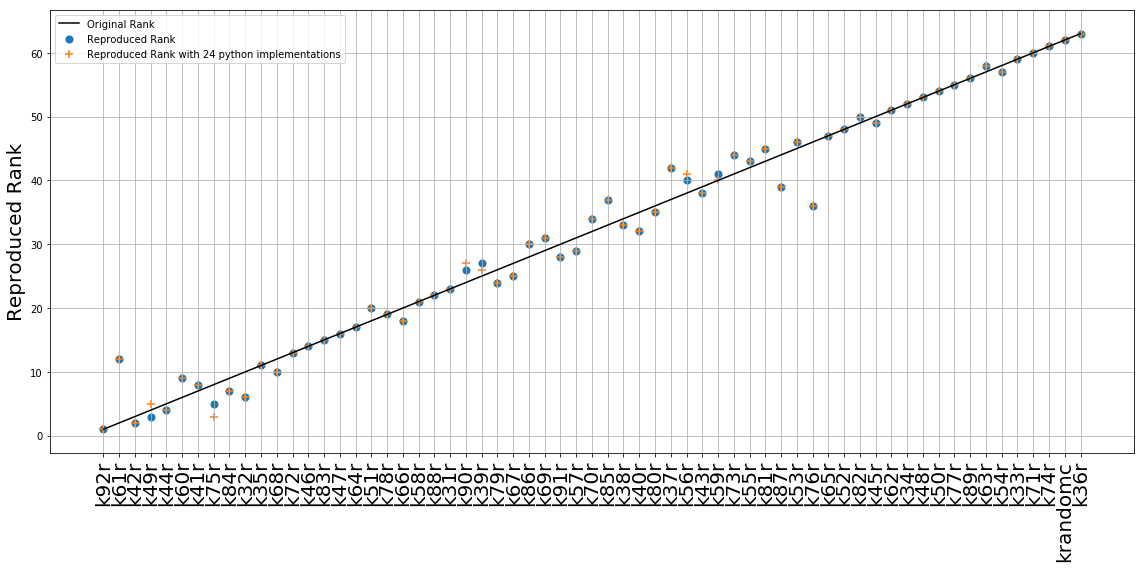

In [27]:
plt.subplots(1, figsize=(16, 8))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))

plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
number_of_python_implementations = len(python_strategies)
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Reproduced Rank with {} python implementations".format(number_of_python_implementations), 
            s=50, marker="+")

plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()

Having examined the remaining outliers I do not see any immediate reason for the discrepancy.

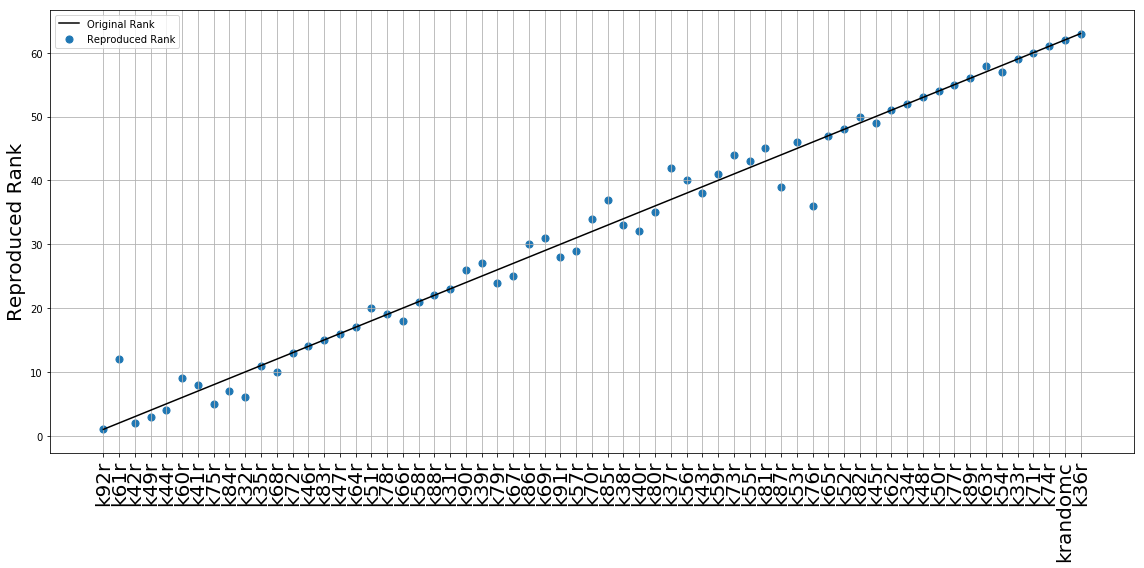

In [28]:
plt.subplots(1, figsize=(16, 8))



plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../assets/original_tournament_rankings.pdf", transparent=True);

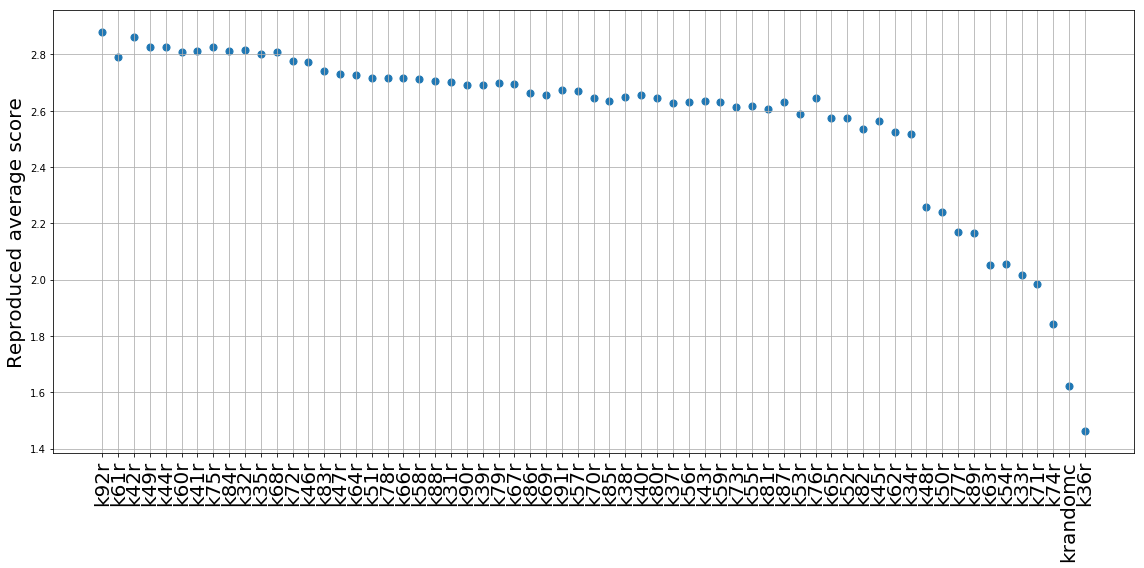

In [29]:
xs = range(len(scores.index))
plt.subplots(1, figsize=(16, 8))
plt.scatter(xs, scores["Scores"].values, s=50)
plt.xticks(xs, scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced average score", fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_scores.pdf", transparent=True);

In [30]:
ranking_df = scores[["Author", "Scores", "Rank", "Original Rank"]].round(4)
ranking_df.head(15)

,Author,Scores,Rank,Original Rank
k92r,Anatol Rapoport,2.8785,1,1
k61r,Danny C Champion,2.7909,12,2
k42r,Otto Borufsen,2.8607,2,3
k49r,Rob Cave,2.8262,3,4
k44r,William Adams,2.8261,4,5
k60r,Jim Graaskamp and Ken Katzen,2.8101,9,6
k41r,Herb Weiner,2.8105,8,7
k75r,Paul D Harrington,2.8260,5,8
k84r,T Nicolaus Tideman and Paula Chieruzz,2.8126,7,9
k32r,Charles Kluepfel,2.8170,6,10


In [31]:
with open("../assets/original_tournament_rankings.tex", "w") as f:
    f.write(ranking_df.head(15).to_latex())

Axelrod's original paper mentioned 5 strategies as representatives: https://github.com/Axelrod-Python/revisiting-axelrod-second/issues/3

Let us reproduce this.

In [32]:
r_squared_values = []
for i, _ in enumerate(axlf.second_tournament_strategies):
    number_of_strategies = i + 1
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=number_of_strategies)
    fit = rfe.fit(scores[axlf.second_tournament_strategies], scores["Scores"])
    model.fit(scores.iloc[:,fit.support_], scores["Scores"])
    scores["Predicted scores {} strategies".format(number_of_strategies)] = model.predict(scores.iloc[:,fit.support_])
    r_squared_values.append(r2_score(scores["Scores"], 
                                     scores["Predicted scores {} strategies".format(number_of_strategies)]))

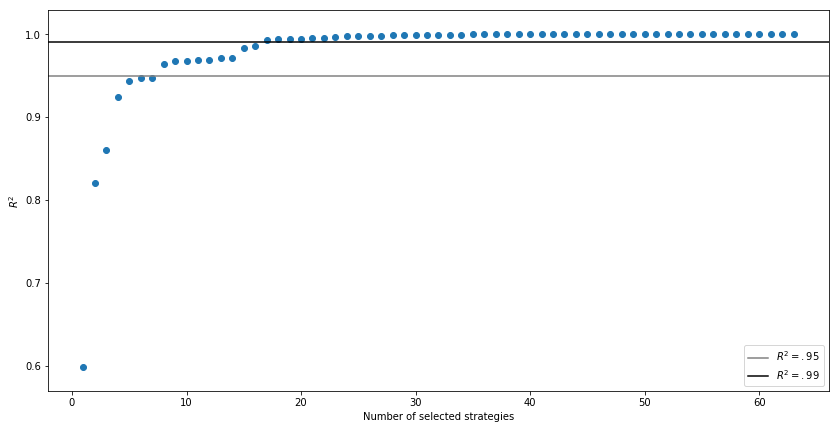

In [33]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(range(1, len(axlf.second_tournament_strategies) + 1), r_squared_values)
plt.axhline(.95, label="$R^2=.95$", color="grey")
plt.axhline(.99, label="$R^2=.99$", color="black")
plt.xlabel("Number of selected strategies")
plt.ylabel("$R^2$")
plt.legend()
plt.savefig("../assets/original_tournament_r_squared_versus_number_of_features.pdf", transparent=True)

In [34]:
def write_linear_model_to_file(file_prefix, number_of_strategies=None, strategies=None):
    model = LinearRegression()
    Y =  scores["Scores"]
    
    if strategies is None:
        rfe = RFE(model, n_features_to_select=number_of_strategies)
        X = scores[axlf.second_tournament_strategies]
        fit = rfe.fit(X, Y)
        strategies = [name 
              for i, name in enumerate(axlf.second_tournament_strategies)
              if fit.support_[i]]      
        
    X = scores[strategies]
    model.fit(X, Y)
    

    coefficients = model.coef_
    intercept = model.intercept_
    
    F_values, p_values = f_regression(X, Y)
        
    
    with open("../assets/" + file_prefix + "_{}_model.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write(pd.DataFrame({"Strategies": strategies + ["Intercept"], 
                              "Coefficients": list(coefficients) + [intercept], 
                              "$p$-value": list(p_values) + ["NA"],
                              "$F$-value": list(F_values) + ["NA"]}
                            )[["Strategies", "Coefficients", "$p$-value", "$F$-value"]].round(3).to_latex(index=False).replace("\\$", "$"))
    
    if number_of_strategies is not None:
        r_squared = r2_score(scores["Scores"], 
                             scores["Predicted scores {} strategies".format(number_of_strategies)])
    else:
        r_squared = r2_score(scores["Scores"], 
                             model.predict(X))
    with open("../assets/" + file_prefix + "_{}_r_squared.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write("{:.4f}".format(r_squared))
        
    with open("data/training_strategies/" + file_prefix + "_{}_strategies.csv".format(number_of_strategies).replace("None_", "",), "w") as f:
        for player, weight in zip(strategies, coefficients):
            f.write("{},{}\n".format(player, weight))
        
    return model, r_squared

In [35]:
for number in [5, 17]:
    write_linear_model_to_file(file_prefix="original_tournament_predictive", 
                               number_of_strategies=number)

In [36]:
representative_strategies = ['k69r', 'k91r', 'k40r', 'k76r', 'k67r']
coefficients = [0.202, 0.198, 0.110, 0.072, 0.086]
intercept= 120 / 151
scores["Representative scores"] = intercept + sum(
                                            scores[strategy] * coefficient 
                                            for strategy, coefficient in zip(representative_strategies, 
                                                                             coefficients))


    
with open("../assets/original_tournament_representative_model.tex", "w") as f:
    f.write(pd.DataFrame({"Strategies": representative_strategies + ["Intercept"], 
                          "Coefficients": list(coefficients) + [intercept]}
                        )[["Strategies", "Coefficients"]].round(3).to_latex(index=False))
    
    
representative_r_squared = r2_score(scores["Scores"], scores["Representative scores"])
with open("../assets/original_tournament_representative_r_squared.tex", "w") as f:
    f.write("{:.4f}".format(representative_r_squared))
    
with open("data/training_strategies/original_tournament_representative_strategies.csv", "w") as f:
    for player, weight in zip(representative_strategies, coefficients):
        f.write("{},{}\n".format(player, weight))

In [37]:
linear_model_with_original_5, linear_model_with_original_5_r_squared  = write_linear_model_to_file(
                           file_prefix="original_tournament_predictive_with_axelrod_5", 
                           strategies=representative_strategies)

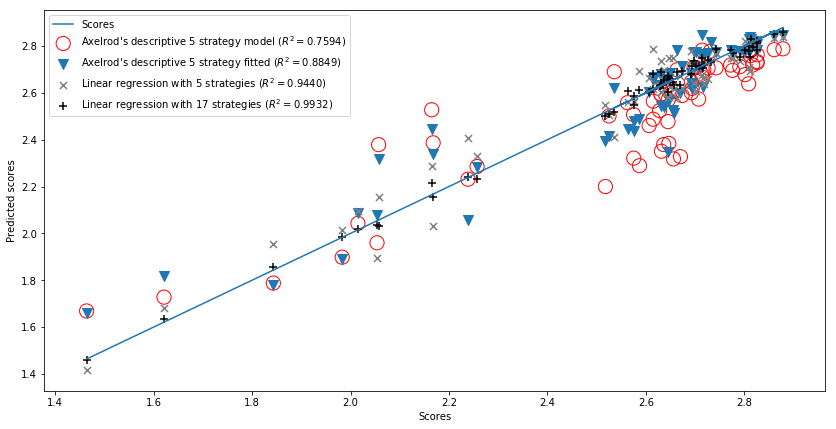

In [38]:
plt.subplots(1, figsize=(14, 7))

plt.plot(scores["Scores"], scores["Scores"])
plt.scatter(scores["Scores"], scores["Representative scores"], 
            label="Axelrod's descriptive 5 strategy model ($R^2={:.4f}$)".format(representative_r_squared),
            s=200,
            facecolors='none', edgecolors='r')

plt.scatter(scores["Scores"], linear_model_with_original_5.predict(scores[representative_strategies]), 
            label="Axelrod's descriptive 5 strategy fitted ($R^2={:.4f}$)".format(linear_model_with_original_5_r_squared),
            s=100,
            marker="v",)
plt.scatter(scores["Scores"], scores["Predicted scores 5 strategies"], 
            label="Linear regression with 5 strategies ($R^2={:.4f}$)".format(r_squared_values[4]),
            s=50,
            marker="x",
            color="grey")
plt.scatter(scores["Scores"], scores["Predicted scores 17 strategies"], 
            label="Linear regression with 17 strategies ($R^2={:.4f}$)".format(r_squared_values[16]),
            s=50,
            marker="+",
            color="black")

plt.legend()
plt.xlabel("Scores")
plt.ylabel("Predicted scores")
plt.savefig("../assets/original_tournament_predictive_score_models.pdf", transparent=True);

# What was the tournament "like"

Let us take a look at summary statistics and cooperation rates.

In [39]:
original_tournament_cooperation_rates = read_payoff_matrix(original_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [40]:
with open("../assets/original_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(original_tournament_cooperation_rates)))
np.mean(original_tournament_cooperation_rates)

0.750427527844103

In [41]:
cooperation_rates = pd.DataFrame(original_tournament_cooperation_rates, 
                                axlf.second_tournament_strategies, 
                                columns=axlf.second_tournament_strategies)

In [42]:
# Columns are opponents
# Rows are players
cooperation_rates = cooperation_rates.merge(scores[["Rank"]], left_index=True, right_index=True)
cooperation_rates["Mean cooperation rate"] = np.mean(original_tournament_cooperation_rates, axis=1)
cooperation_rates.sort_values("Rank", inplace=True)

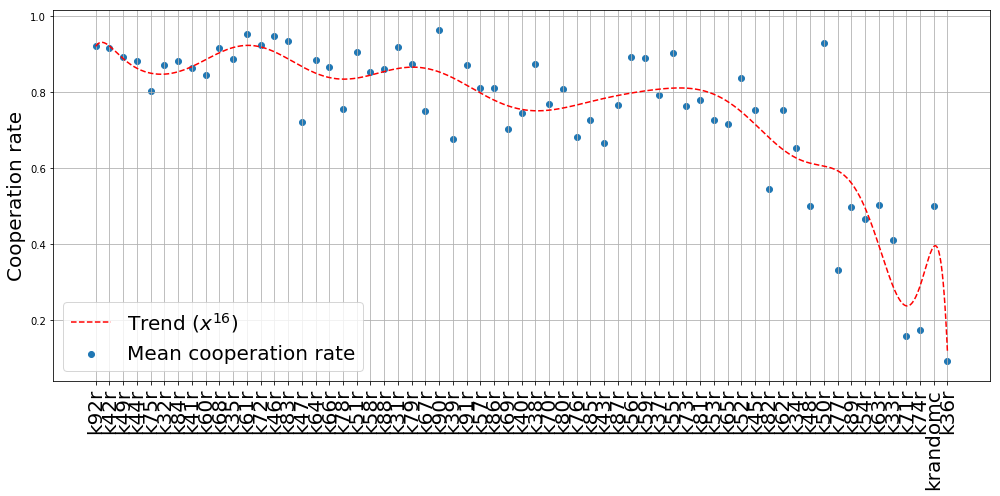

In [43]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(cooperation_rates["Rank"], cooperation_rates["Mean cooperation rate"])

degree = 16
z = np.polyfit(cooperation_rates["Rank"], cooperation_rates["Mean cooperation rate"], degree)
p = np.poly1d(z)
x = np.linspace(1, cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend ($x^{{{}}}$)".format(degree))

plt.ylabel("Cooperation rate", fontsize=20)
plt.xticks(range(1, len(cooperation_rates) + 1), cooperation_rates.index, rotation=90, fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

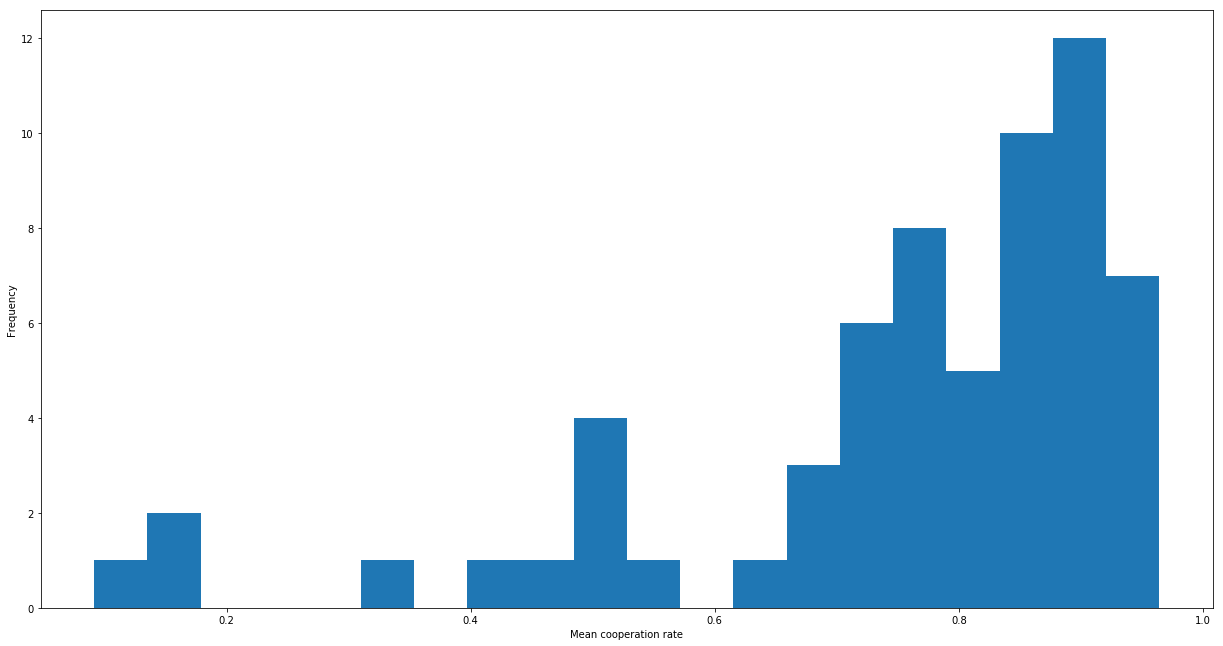

In [44]:
plt.subplots(1, figsize=(21, 11))

plt.hist(cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/original_tournament_cooperation_rates.pdf", transparent=True)

In [45]:
def matrix_heatmap(matrix, player_names, filename):
    number_of_players = len(player_names)
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename, transparent=True);

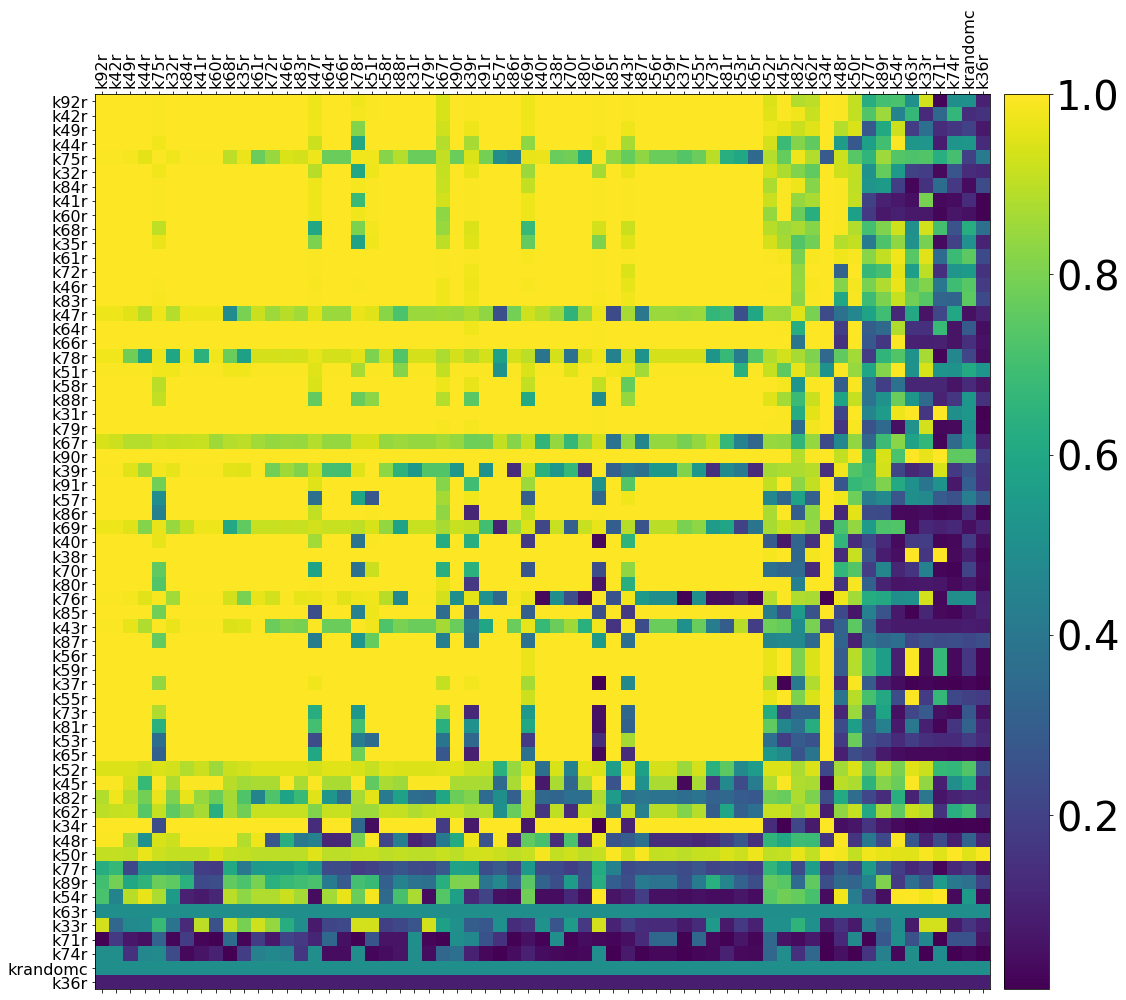

In [46]:
matrix_heatmap(cooperation_rates[cooperation_rates.index], cooperation_rates.index, 
               "../assets/original_tournament_pairwise_cooperation_rates.pdf")

## Adding another strategy from the library

In [47]:
library_summary = pd.read_csv("data/std_summary_v_4.2.0.csv", index_col="Name")
library_summary["Rank"] += 1

In [48]:
original_tournament_with_extra_data_path = pathlib.Path("./data/original_tournament_with_extra_strategy/")

In [49]:
data = {"Name": [], 
        "Repetitions": [], 
        "Rank": [],
        "Library Rank": [],
        "Cooperation Rate against opponents": [],
        "Cooperation Rate from opponents": [],
        "Score": [],
        "Winner": [],
        "Winner score": []}
for index, strategy in enumerate(axl.strategies):
    player = strategy()
    name = player.name
    if name not in ["Alexei", "Contrite Tit For Tat"]:  # Removing these as they correspond to TfT in these conditions

        representation = str(player)
        pattern = "*player_{}*{}*payoff_matrix.gz".format(index, name)
        files = list(original_tournament_with_extra_data_path.glob(pattern))
        if len(files) > 0:
            payoff_matrix, repetitions = read_payoff_matrix(files)
            mean_scores = np.mean(payoff_matrix, axis=1)


            pattern = "*{}*cooperation_rates.gz".format(name)
            files = list(original_tournament_with_extra_data_path.glob(pattern))
            cooperation_matrix = read_payoff_matrix(files)[0].transpose()
            player_against_opponents_cooperation_rate = np.mean(cooperation_matrix, axis=1)[-1]
            opponents_against_player_cooperation_rate = np.mean(cooperation_matrix, axis=0)[-1]

            player_score = mean_scores[-1]
            player_rank = sorted(mean_scores, reverse=True).index(player_score) + 1
            try:
                winner = axlf.second_tournament_strategies[np.argmax(mean_scores)]
            except IndexError:
                winner = name

            data["Name"].append(name)
            data["Repetitions"].append(repetitions)
            data["Rank"].append(player_rank)
            data["Score"].append(player_score)
            data["Library Rank"].append(library_summary["Rank"][representation])
            data["Cooperation Rate against opponents"].append(player_against_opponents_cooperation_rate)
            data["Cooperation Rate from opponents"].append(opponents_against_player_cooperation_rate)
            data["Winner"].append(winner)
            data["Winner score"].append(np.max(mean_scores))
        
extra_strategy_df = pd.DataFrame(data).set_index("Name").sort_values(["Rank", "Score"])

In [50]:
extra_strategy_repetitions = extra_strategy_df["Repetitions"].min()
with open("../assets/number_of_extra_strategy_repetitions.tex", "w") as f:
    f.write(str(extra_strategy_repetitions))
extra_strategy_repetitions

12500

In [51]:
with open("../assets/original_tournament_with_extra_strategy_summary.tex", "w") as f:
    columns = ["Cooperation Rate against opponents", "Cooperation Rate from opponents", "Library Rank", "Rank", "Score", "Winner"]
    f.write(extra_strategy_df.head(20)[columns].round(3).to_latex().replace("\_", "\\_"))
extra_strategy_df

,Repetitions,Rank,Library Rank,Cooperation Rate against opponents,Cooperation Rate from opponents,Score,Winner,Winner score
Name,,,,,,,,
Meta Majority Long Memory,12500,2,80,0.896945,0.909507,2.865933,k92r,2.880320
Meta Majority,12500,2,90,0.883651,0.893281,2.868368,k92r,2.880458
Firm But Fair,12500,2,86,0.941835,0.925505,2.868864,k92r,2.880316
ZD-GTFT-2,12500,2,52,0.941370,0.928705,2.876369,k92r,2.880305
Soft Joss,12500,2,54,0.934654,0.926934,2.878159,k92r,2.880479
Adaptive Tit For Tat,12500,2,84,0.923048,0.922484,2.880069,k92r,2.880468
PSO Gambler 2_2_2 Noise 05,12500,3,16,0.865511,0.880021,2.833071,k92r,2.880438
Omega TFT,12500,3,13,0.887917,0.903948,2.853401,k92r,2.880342
GTFT,12500,3,59,0.946278,0.927530,2.854674,k92r,2.880487


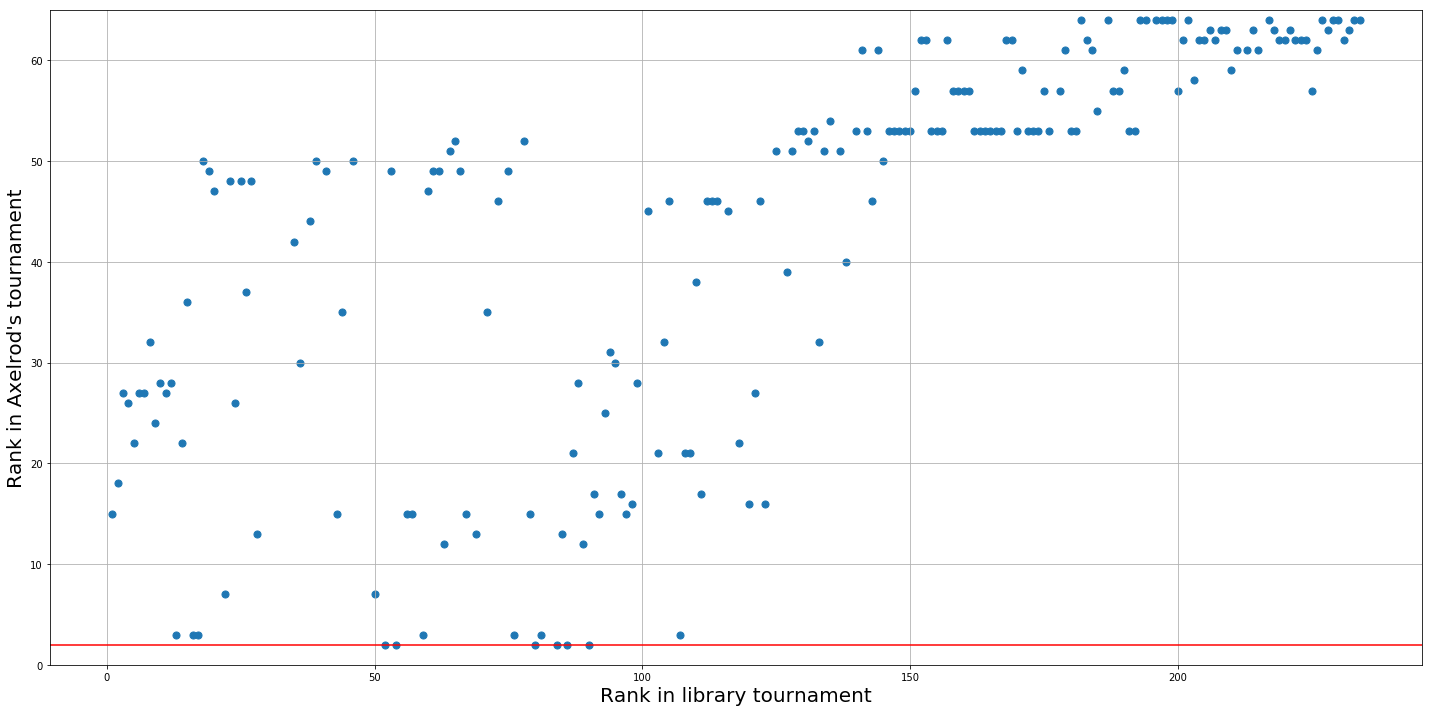

In [52]:
plt.subplots(1, figsize=(20, 10))

extra_strategy_df.sort_values("Library Rank", inplace=True)
plt.scatter(extra_strategy_df["Library Rank"], extra_strategy_df["Rank"], s=50)
plt.ylabel("Rank in Axelrod's tournament", fontsize=20)
plt.xlabel("Rank in library tournament", fontsize=20)
plt.ylim(0, len(axlf.second_tournament_strategies) + 2)
plt.grid()
plt.axhline(2, color="red")
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_ranks_vs_library_ranks.pdf", transparent=True);

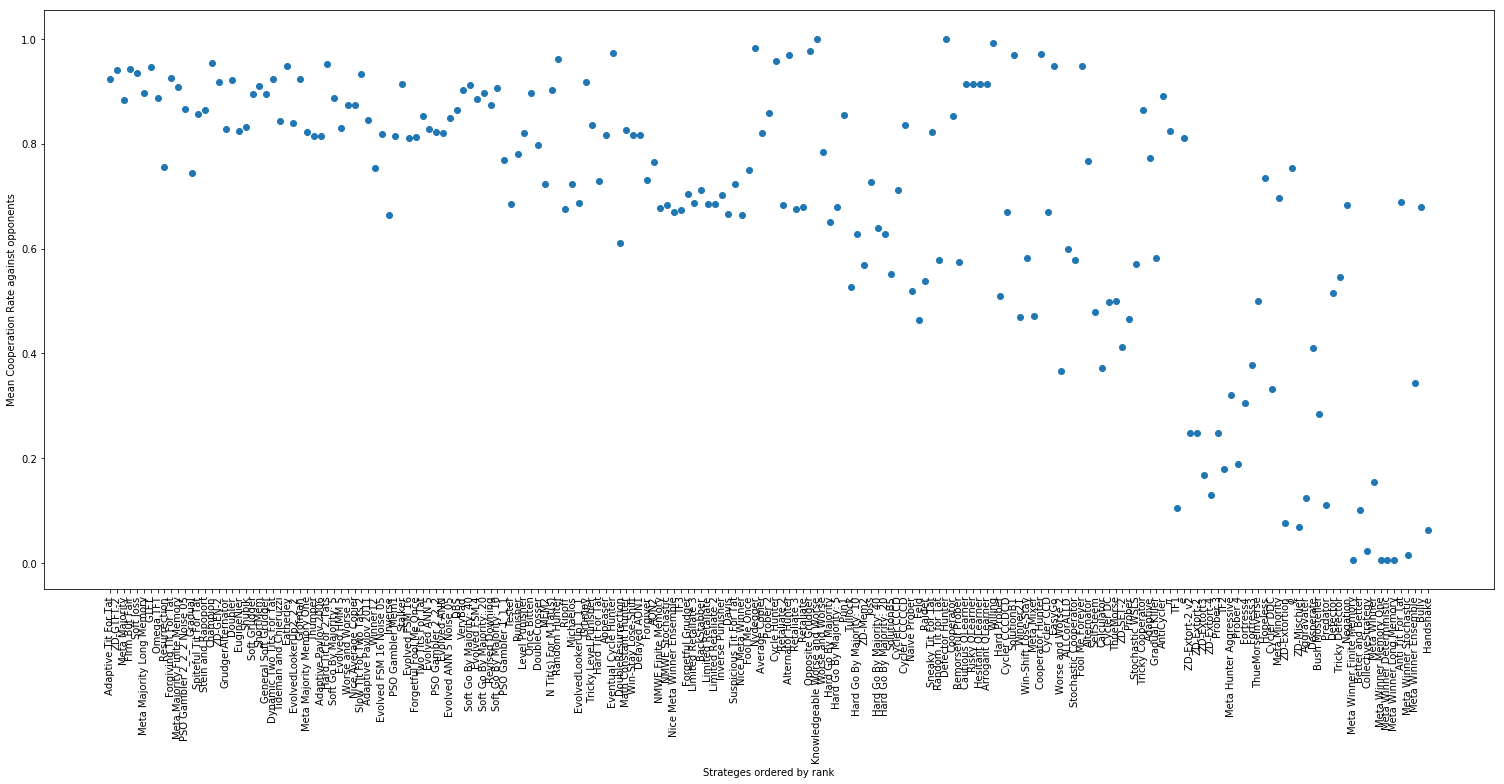

In [53]:
plt.subplots(1, figsize=(21, 11))

extra_strategy_df.sort_values("Rank", inplace=True)

plt.scatter(range(1, len(extra_strategy_df.index) + 1), extra_strategy_df["Cooperation Rate against opponents"])
plt.xlabel("Strateges ordered by rank")
plt.ylabel("Mean Cooperation Rate against opponents")
plt.xticks(range(1, len(extra_strategy_df.index) + 1), 
           extra_strategy_df.index, rotation=90)
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_cooperation_rates_vs_opponents.pdf", transparent=True);

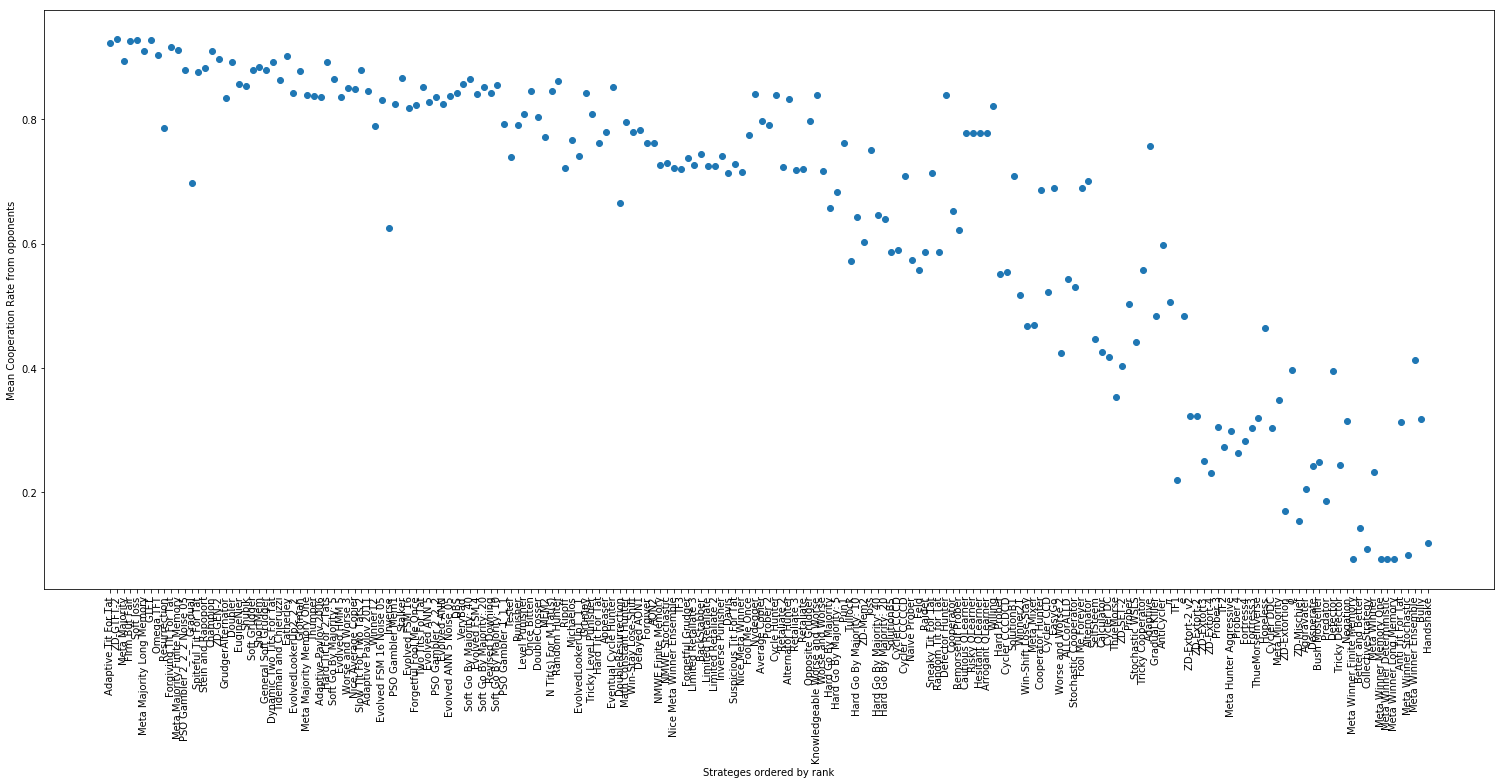

In [54]:
plt.subplots(1, figsize=(21, 11))

plt.scatter(range(1, len(extra_strategy_df.index) + 1), extra_strategy_df["Cooperation Rate from opponents"])
plt.xlabel("Strateges ordered by rank")
plt.ylabel("Mean Cooperation Rate from opponents")
plt.xticks(range(1, len(extra_strategy_df.index) + 1), 
           extra_strategy_df.index, rotation=90)
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_cooperation_rates_from_opponents.pdf", transparent=True);

## Investigating the S&P strategies

In [55]:
from run_sp_tournament import players as sp_players

sp_player_names = []
for p in sp_players:
    try:
        sp_player_names.append(p.original_name)
    except AttributeError:
        sp_player_names.append(p.name)

In [56]:
sp_tournament_data_path = pathlib.Path("./data/sp_tournament/")
sp_tournament_payoff_matrix, sp_repetitions = read_payoff_matrix(sp_tournament_data_path.glob("*payoff_matrix.gz"))

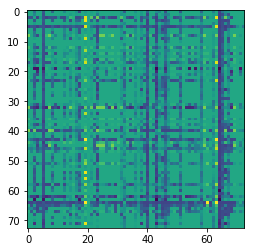

In [57]:
plt.imshow(sp_tournament_payoff_matrix)

In [58]:
with open("../assets/number_of_sp_repetitions.tex", "w") as f:
    f.write(str(sp_repetitions))

sp_repetitions

30000

In [59]:
assert sp_tournament_payoff_matrix.shape == (len(sp_players), len(sp_players))

In [60]:
sp_scores = pd.DataFrame(sp_tournament_payoff_matrix, 
                         sp_player_names, 
                         sp_player_names)

In [61]:
dummy_dict = {"original_rank": -1, "author": "NA"}
sp_scores["Scores"] = np.mean(sp_tournament_payoff_matrix, axis=1)
sp_scores["Rank"] = sp_scores["Scores"].rank(ascending=False).astype(int)
sp_scores["Original Rank"] =  [axlf.characteristics.get(name, dummy_dict)["original_rank"] 
                               for name in sp_scores.index]

sp_scores["Original Author"] =  [axlf.characteristics.get(name, dummy_dict)["author"] 
                        for name in sp_scores.index]

sp_scores = sp_scores.merge(scores[["Rank"]].rename(columns={"Rank": "Reproduced Rank"}), left_index=True, right_index=True, how="left")
sp_scores.fillna('-1', inplace=True)
sp_scores.sort_values("Rank", inplace=True)

In [62]:
sp_scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,Hard Tit For Tat,Hard Tit For 2 Tats,GTFT,Win-Stay Lose-Shift,ZD-GTFT-2,Scores,Rank,Original Rank,Original Author,Reproduced Rank
ZD-GTFT-2,3.0,3.0,2.873065,3.0,3.0,1.043298,3.0,3.0,2.982081,3.0,...,3.0,3.0,3.0,3.0,3.0,2.833918,1,-1,NA,-1
k42r,3.0,3.0,2.142544,3.0,3.0,1.195263,3.0,3.0,2.993421,3.0,...,3.0,3.0,3.0,3.0,3.0,2.825080,2,3,Otto Borufsen,2
GTFT,3.0,3.0,2.741954,3.0,3.0,0.925808,3.0,3.0,2.948001,3.0,...,3.0,3.0,3.0,3.0,3.0,2.818532,3,-1,NA,-1
k92r,3.0,3.0,2.901316,3.0,3.0,1.253464,3.0,3.0,2.993421,3.0,...,3.0,3.0,3.0,3.0,3.0,2.812061,4,1,Anatol Rapoport,1
k49r,3.0,3.0,2.304192,3.0,3.0,1.278350,3.0,3.0,2.904765,3.0,...,3.0,3.0,3.0,3.0,3.0,2.787399,5,4,Rob Cave,3


In [63]:
sp_ranking_df = sp_scores[["Original Author", "Scores", "Rank", "Original Rank", "Reproduced Rank"]].round(4)
sp_ranking_df.head(15)

,Original Author,Scores,Rank,Original Rank,Reproduced Rank
ZD-GTFT-2,NA,2.8339,1,-1,-1
k42r,Otto Borufsen,2.8251,2,3,2
GTFT,NA,2.8185,3,-1,-1
k92r,Anatol Rapoport,2.8121,4,1,1
k49r,Rob Cave,2.7874,5,4,3
k75r,Paul D Harrington,2.7870,6,8,5
k44r,William Adams,2.7811,7,5,4
k61r,Danny C Champion,2.7722,8,2,12
k68r,Fransois Leyvraz,2.7679,9,12,10
k41r,Herb Weiner,2.7620,10,7,8


In [64]:
with open("../assets/sp_tournament_rankings.tex", "w") as f:
    f.write(sp_ranking_df.head(15).to_latex().replace("-1", "NA"))

In [65]:
sp_tournament_cooperation_rates = read_payoff_matrix(sp_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [66]:
with open("../assets/sp_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(sp_tournament_cooperation_rates)))
np.mean(sp_tournament_cooperation_rates)

0.7314425635713886

In [67]:
sp_cooperation_rates = pd.DataFrame(sp_tournament_cooperation_rates, 
                                    sp_player_names, 
                                    columns=sp_player_names)

In [68]:
sp_cooperation_rates = sp_cooperation_rates.merge(sp_scores[["Rank"]], left_index=True, right_index=True)
sp_cooperation_rates["Mean cooperation rate"] = np.mean(sp_tournament_cooperation_rates, axis=1)
sp_cooperation_rates.sort_values("Rank", inplace=True)

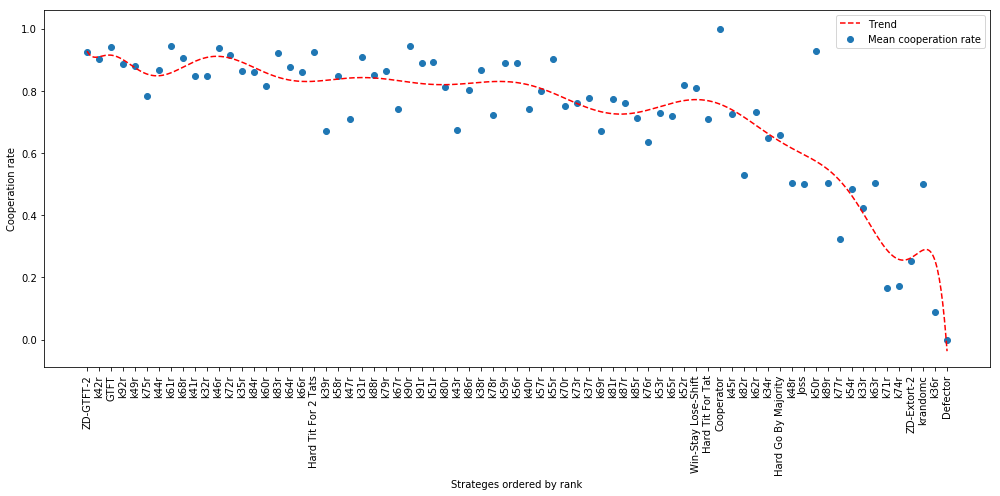

In [69]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(sp_cooperation_rates["Rank"], sp_cooperation_rates["Mean cooperation rate"])

z = np.polyfit(sp_cooperation_rates["Rank"], sp_cooperation_rates["Mean cooperation rate"], 16)
p = np.poly1d(z)
x = np.linspace(1, sp_cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend")


plt.xlabel("Strateges ordered by rank")
plt.ylabel("Cooperation rate")
plt.xticks(range(1, len(sp_cooperation_rates) + 1), sp_cooperation_rates.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../assets/sp_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

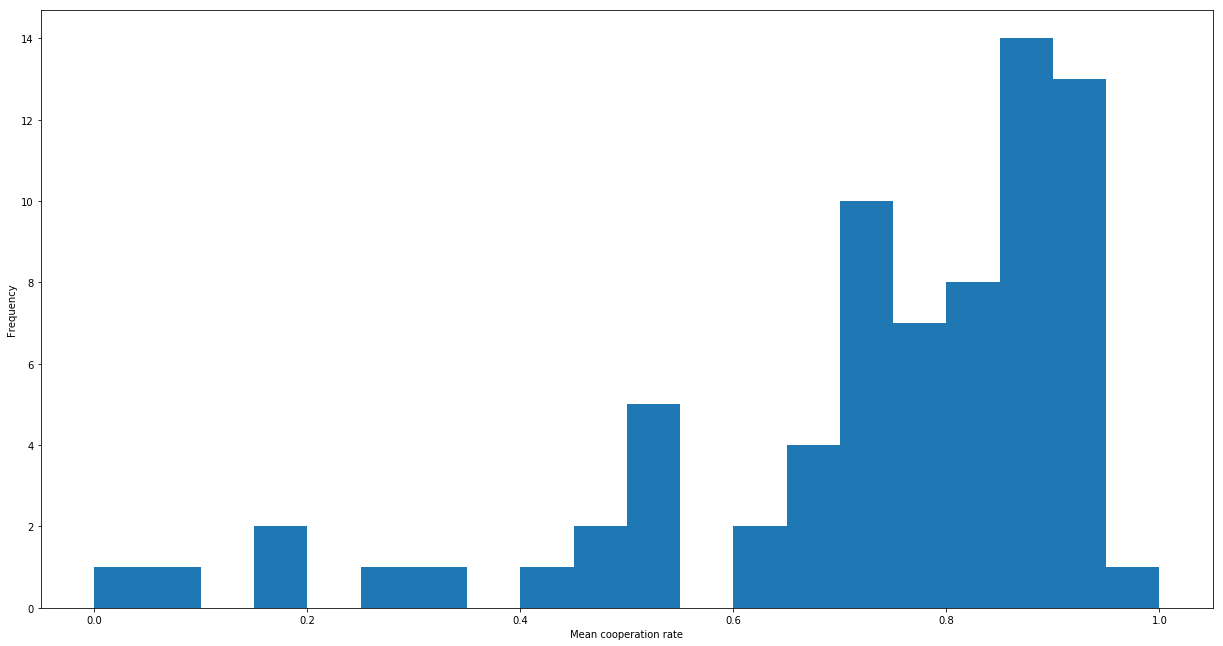

In [70]:
plt.subplots(1, figsize=(21, 11))

plt.hist(sp_cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/sp_tournament_cooperation_rates.pdf", transparent=True)

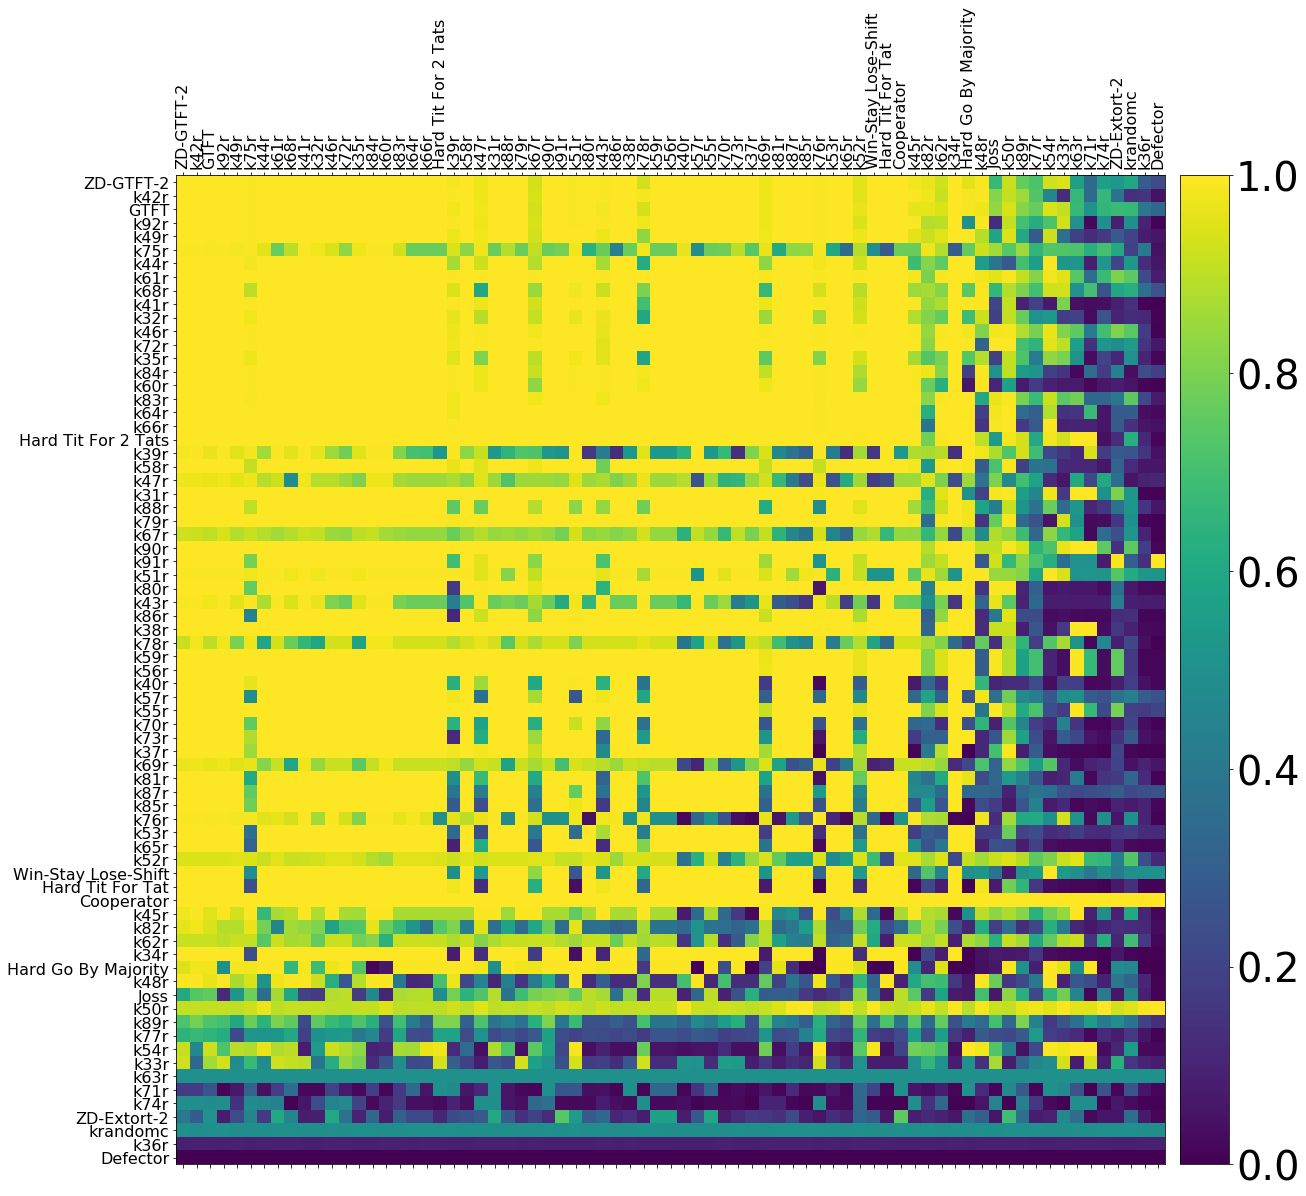

In [71]:
matrix_heatmap(sp_cooperation_rates[sp_cooperation_rates.index], sp_cooperation_rates.index, 
               "../assets/sp_tournament_pairwise_cooperation_rates.pdf")

## Investigating the full tournament.

In [72]:
from run_full_tournament import players as full_players

full_player_names = []
for p in full_players:
    try:
        full_player_names.append(p.original_name)
    except AttributeError:
        full_player_names.append(p.name)
        
library_names_to_repr = {s.name: s().__repr__() for s in axl.strategies}
assert len(full_player_names) == 262

In [73]:
with open("../assets/library_tournament_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(library_summary["Cooperation_rating"])))
np.mean(library_summary["Cooperation_rating"])

0.6243530253842485

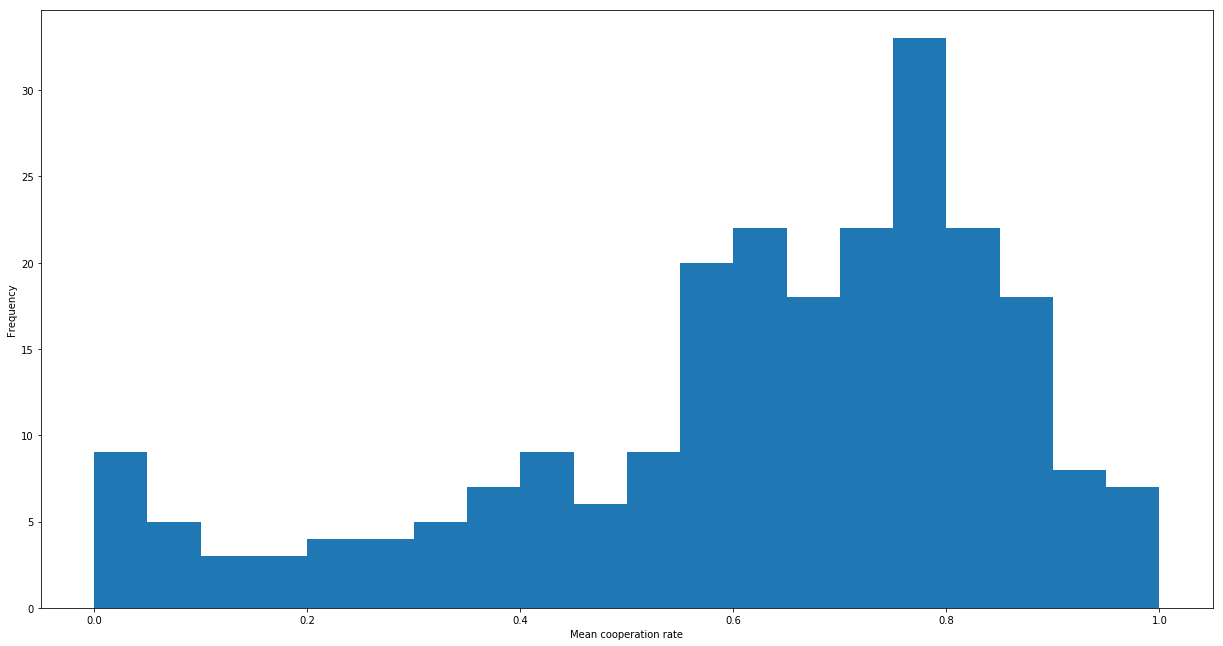

In [74]:
plt.subplots(1, figsize=(21, 11))

plt.hist(library_summary["Cooperation_rating"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/library_tournament_cooperation_rates.pdf", transparent=True)

In [75]:
full_tournament_data_path = pathlib.Path("./data/full_tournament/")
full_tournament_payoff_matrix, full_repetitions = read_payoff_matrix(full_tournament_data_path.glob("*payoff_matrix.gz"))

In [76]:
with open("../assets/number_of_full_repetitions.tex", "w") as f:
    f.write(str(full_repetitions))
full_repetitions

20000

In [77]:
assert full_tournament_payoff_matrix.shape == (len(full_players), len(full_players))

In [78]:
full_scores = pd.DataFrame(full_tournament_payoff_matrix, 
                           full_player_names, 
                           full_player_names)

In [79]:
dummy_dict = {"original_rank": -1, "author": "NA"}
full_scores["Scores"] = np.mean(full_tournament_payoff_matrix, axis=1)
full_scores["Rank"] = full_scores["Scores"].rank(ascending=False).astype(int)
full_scores["Original Rank"] =  [axlf.characteristics.get(name, dummy_dict)["original_rank"] 
                               for name in full_scores.index]
full_scores["Library Rank"] =  [library_summary["Rank"].get(library_names_to_repr.get(name, "No rank"), -1) 
                                 for name in full_scores.index]

full_scores["Original Author"] =  [axlf.characteristics.get(name, dummy_dict)["author"] 
                        for name in full_scores.index]

full_scores = full_scores.merge(scores[["Rank"]].rename(columns={"Rank": "Reproduced Rank"}), left_index=True, right_index=True, how="left")
full_scores.fillna('-1', inplace=True)
full_scores.sort_values("Rank", inplace=True)

In [80]:
full_scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,NMWE Memory One,NMWE Stochastic,Nice Meta Winner,Nice Meta Winner Ensemble,Scores,Rank,Original Rank,Library Rank,Original Author,Reproduced Rank
EvolvedLookerUp2_2_2,3.0,3.0,2.035762,3.0,3.0,1.266890,3.0,3.0,2.976159,3.0,...,3.0,3.0,3.0,3.0,2.834537,1,-1,1,NA,-1
Evolved HMM 5,3.0,3.0,1.006968,3.0,3.0,1.035779,3.0,3.0,2.848517,3.0,...,3.0,3.0,3.0,3.0,2.820983,2,-1,2,NA,-1
Evolved FSM 16 Noise 05,3.0,3.0,1.331126,3.0,3.0,1.214197,3.0,3.0,1.631788,3.0,...,3.0,3.0,3.0,3.0,2.805683,3,-1,5,NA,-1
Evolved FSM 16,3.0,3.0,1.307285,3.0,3.0,0.839303,3.0,3.0,1.467550,3.0,...,3.0,3.0,3.0,3.0,2.801489,4,-1,4,NA,-1
PSO Gambler 2_2_2,3.0,3.0,2.013093,3.0,3.0,1.194750,3.0,3.0,2.443709,3.0,...,3.0,3.0,3.0,3.0,2.799665,5,-1,3,NA,-1


In [81]:
full_ranking_df = full_scores[["Original Author", "Scores", "Rank", "Library Rank",  "Original Rank","Reproduced Rank"]].round(4)
full_ranking_df.head(20)

,Original Author,Scores,Rank,Library Rank,Original Rank,Reproduced Rank
EvolvedLookerUp2_2_2,NA,2.8345,1,1,-1,-1
Evolved HMM 5,NA,2.8210,2,2,-1,-1
Evolved FSM 16 Noise 05,NA,2.8057,3,5,-1,-1
Evolved FSM 16,NA,2.8015,4,4,-1,-1
PSO Gambler 2_2_2,NA,2.7997,5,3,-1,-1
Evolved ANN,NA,2.7898,6,7,-1,-1
Evolved ANN 5,NA,2.7891,7,6,-1,-1
Omega TFT,NA,2.7863,8,13,-1,-1
PSO Gambler Mem1,NA,2.7811,9,9,-1,-1
Evolved FSM 4,NA,2.7789,10,10,-1,-1


In [ ]:
with open("../assets/full_tournament_rankings.tex", "w") as f:
    f.write(full_ranking_df.head(20).to_latex().replace("-1", "NA").replace("\_", "\\_"))

In [ ]:
full_tournament_cooperation_rates = read_payoff_matrix(full_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [ ]:
with open("../assets/full_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(full_tournament_cooperation_rates)))
np.mean(full_tournament_cooperation_rates)

In [ ]:
full_cooperation_rates = pd.DataFrame(full_tournament_cooperation_rates, 
                                      full_player_names, 
                                      columns=full_player_names)

In [ ]:
full_cooperation_rates = full_cooperation_rates.merge(full_scores[["Rank"]], left_index=True, right_index=True)
full_cooperation_rates["Mean cooperation rate"] = np.mean(full_tournament_cooperation_rates, axis=1)
full_cooperation_rates.sort_values("Rank", inplace=True)

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.scatter(full_cooperation_rates["Rank"], full_cooperation_rates["Mean cooperation rate"])

z = np.polyfit(full_cooperation_rates["Rank"], full_cooperation_rates["Mean cooperation rate"], 16)
p = np.poly1d(z)
x = np.linspace(1, full_cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend")

plt.xlabel("Strateges ordered by rank")
plt.ylabel("Cooperation rate")
plt.xticks(range(1, len(full_cooperation_rates) + 1), full_cooperation_rates.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../assets/full_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.hist(full_cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/full_tournament_cooperation_rates.pdf", transparent=True)

In [ ]:
matrix_heatmap(full_cooperation_rates[full_cooperation_rates.index], full_cooperation_rates.index, 
               "../assets/full_tournament_pairwise_cooperation_rates.pdf")